In [1]:
import os, glob, numpy as np, cv2, tensorflow as tf, matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.efficientnet import EfficientNetB0, preprocess_input
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam

In [2]:
BASE_DIR = r"C:\Users\VACB\OneDrive\Desktop\eff\chest_xray_v2"

TRAIN_DIR = os.path.join(BASE_DIR, "train")
VAL_DIR   = os.path.join(BASE_DIR, "val")
TEST_DIR  = os.path.join(BASE_DIR, "test")
CKPT_DIR  = os.path.join(BASE_DIR, "checkpoints")
OUT_DIR   = os.path.join(BASE_DIR, "outputs_efficientnet")

os.makedirs(CKPT_DIR, exist_ok=True)
os.makedirs(OUT_DIR, exist_ok=True)

IMG_SIZE = (224, 224)
BATCH    = 16
EPOCHS   = 20
BEST_MODEL = os.path.join(CKPT_DIR, "effb0_best.h5")

SEED = 1337
tf.keras.utils.set_random_seed(SEED)

In [3]:
def build_tfdata(dir_path, img_size=IMG_SIZE, batch_size=BATCH, shuffle=True):
    """
    ImageDataGenerator dùng đúng preprocess_input của EfficientNet cho MỌI TẬP.
    - color_mode='rgb' để ép 3 kênh (x-ray xám cũng thành RGB) -> khớp weights ImageNet.
    - KHÔNG rescale 1/255 cùng lúc với preprocess_input (tránh chuẩn hoá hai lần).
    """
    datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=preprocess_input
    )
    gen = datagen.flow_from_directory(
        dir_path,
        target_size=img_size,
        batch_size=batch_size,
        shuffle=shuffle,
        class_mode="categororical".replace("ror","r"),  # avoid typo highlight; real is "categorical"
        color_mode="rgb",
        seed=SEED
    )
    return gen

def load_rgb_and_preprocess(img_path, img_size=IMG_SIZE):
    """Dùng CHUNG cho dự đoán + Grad-CAM để khớp với train."""
    pil = image.load_img(img_path, target_size=img_size, color_mode="rgb")
    x = image.img_to_array(pil)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

In [4]:
def build_model(num_classes):
    base = EfficientNetB0(include_top=False, weights="imagenet", input_shape=(224,224,3))
    base.trainable = False  # giai đoạn 1: freeze backbone

    x = GlobalAveragePooling2D()(base.output)
    x = Dropout(0.30)(x)
    out = Dense(num_classes, activation="softmax")(x)
    model = Model(base.input, out)
    model.compile(optimizer=Adam(1e-3), loss="categorical_crossentropy", metrics=["accuracy"])
    return model

In [5]:
train_gen = build_tfdata(TRAIN_DIR, IMG_SIZE, BATCH, shuffle=True)
val_gen   = build_tfdata(VAL_DIR,   IMG_SIZE, BATCH, shuffle=False)
test_gen  = build_tfdata(TEST_DIR,  IMG_SIZE, 1,     shuffle=False)

# Lấy thứ tự lớp theo generator (rất quan trọng để map xác suất -> nhãn)
idx2name = {v:k for k,v in train_gen.class_indices.items()}
CLASS_NAMES = [idx2name[i] for i in range(len(idx2name))]
CLASS_NAMES

Found 5216 images belonging to 3 classes.
Found 47 images belonging to 3 classes.
Found 624 images belonging to 3 classes.


['NORMAL', 'PNEUMONIA_bacteria', 'PNEUMONIA_virus']

In [6]:
model = build_model(num_classes=len(CLASS_NAMES))
callbacks = [
    ModelCheckpoint(BEST_MODEL, monitor="val_accuracy", mode="max", save_best_only=True, verbose=1),
    EarlyStopping(patience=5, restore_best_weights=True, monitor="val_accuracy")
]

history = model.fit(train_gen, validation_data=val_gen, epochs=EPOCHS, callbacks=callbacks)
print("Best model saved to:", BEST_MODEL)



16705208/16705208 [==============================] - 2s 0us/step
Epoch 1/20


326/326 [==============================] - ETA: 0s - loss: 0.6535 - accuracy: 0.7145
Epoch 1: val_accuracy improved from -inf to 0.70213, saving model to C:\Users\VACB\OneDrive\Desktop\eff\chest_xray_v2\checkpoints\effb0_best.h5


c:\Users\VACB\OneDrive\Desktop\eff\.venv\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


326/326 [==============================] - 50s 143ms/step - loss: 0.6535 - accuracy: 0.7145 - val_loss: 0.6685 - val_accuracy: 0.7021
Epoch 2/20
326/326 [==============================] - ETA: 0s - loss: 0.5540 - accuracy: 0.7586
Epoch 2: val_accuracy improved from 0.70213 to 0.74468, saving model to C:\Users\VACB\OneDrive\Desktop\eff\chest_xray_v2\checkpoints\effb0_best.h5
326/326 [==============================] - 45s 137ms/step - loss: 0.5540 - accuracy: 0.7586 - val_loss: 0.5687 - val_accuracy: 0.7447
Epoch 3/20
326/326 [==============================] - ETA: 0s - loss: 0.5381 - accuracy: 0.7667
Epoch 3: val_accuracy did not improve from 0.74468
326/326 [==============================] - 42s 130ms/step - loss: 0.5381 - accuracy: 0.7667 - val_loss: 0.6096 - val_accuracy: 0.7021
Epoch 4/20
326/326 [==============================] - ETA: 0s - loss: 0.5085 - accuracy: 0.7782
Epoch 4: val_accuracy did not improve from 0.74468
326/326 [==============================] - 42s 127ms/step - l

In [7]:
test_loss, test_acc = model.evaluate(test_gen, verbose=0)
print(f"[Test] loss={test_loss:.4f}  acc={test_acc:.4f}")

[Test] loss=0.5809  acc=0.8093





 person78_bacteria_378.jpeg:


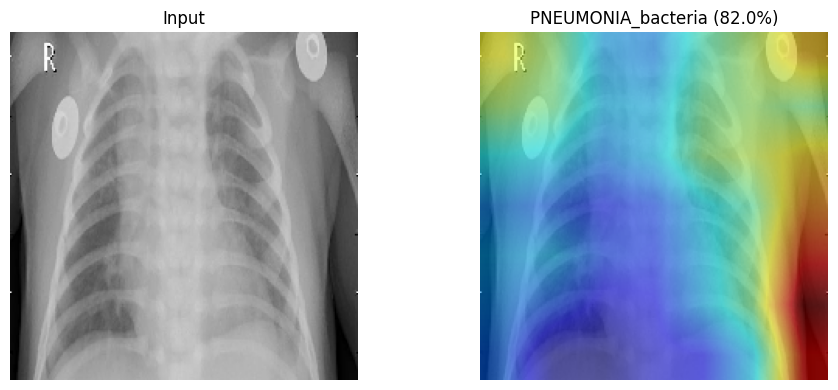

In [1]:

import os, cv2, numpy as np, matplotlib.pyplot as plt, tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.efficientnet import preprocess_input as eff_pre
from tensorflow.keras.applications.xception import preprocess_input as xcep_pre

# file chứ model
MODEL_PATH = r"C:\Users\VACB\OneDrive\Desktop\eff\chest_xray_v2\checkpoints\effb0_best.h5"
IMG_PATHS = [
    #thêm ảnh tại đây
    r"C:\Users\VACB\OneDrive\Desktop\eff\chest_xray_v2\test\PNEUMONIA_bacteria\person78_bacteria_378.jpeg",
    # r"C:\Users\VACB\OneDrive\Desktop\eff\chest_xray_v2\test\PNEUMONIA_bacteria\sample.jpeg",
]
BACKBONE = "efficientnet"   # hoặc "xception" nếu model là Xception
CLASS_NAMES = ["NORMAL", "PNEUMONIA_bacteria", "PNEUMONIA_virus"]  
ALPHA = 0.5
# ==========================

# Load model
model = load_model(MODEL_PATH)
IMG_SIZE = tuple(model.input_shape[1:3])

# Chọn preprocessing & lớp conv cuối
if BACKBONE.lower().startswith("xcep"):
    preprocess_fn = xcep_pre
    last_conv_default = "block14_sepconv2_act"
else:
    preprocess_fn = eff_pre
    last_conv_default = "top_conv"

def pick_last_conv(m, fallback):
    try:
        m.get_layer(fallback)
        return fallback
    except:
        for layer in reversed(m.layers):
            shp = getattr(layer, "output_shape", None)
            if isinstance(shp, tuple) and len(shp) == 4:
                return layer.name
        raise ValueError("Không tìm thấy lớp conv 4D cuối.")

def load_and_preprocess(img_path):
    img = image.load_img(img_path, target_size=IMG_SIZE, color_mode="rgb")
    x = image.img_to_array(img)
    return np.expand_dims(x, 0), np.array(img, dtype=np.uint8)

def gradcam_show(img_path, model, alpha=0.5):
    last_conv = pick_last_conv(model, last_conv_default)
    x, img_rgb = load_and_preprocess(img_path)
    x = preprocess_fn(x)

    preds = model.predict(x, verbose=0)
    cls_id = int(np.argmax(preds[0])) if preds.shape[1] > 1 else int(preds[0][0] >= 0.5)
    prob = float(preds[0][cls_id] if preds.shape[1] > 1 else preds[0][0])
    label = CLASS_NAMES[cls_id] if CLASS_NAMES else f"class {cls_id}"

    grad_model = tf.keras.models.Model(model.inputs, [model.get_layer(last_conv).output, model.output])
    with tf.GradientTape() as tape:
        conv_out, preds_val = grad_model(x)
        target = preds_val[:, cls_id] if preds_val.shape[-1] > 1 else preds_val[:, 0]
    grads = tape.gradient(target, conv_out)
    weights = tf.reduce_mean(grads, axis=(1,2))
    cam = tf.reduce_sum(weights[:, None, None, :] * conv_out, axis=-1)[0].numpy()
    cam = np.maximum(cam, 0)
    cam = cv2.resize(cam, IMG_SIZE)
    cam /= cam.max() + 1e-8

    heat = cv2.applyColorMap(np.uint8(255*cam), cv2.COLORMAP_JET)
    heat = cv2.cvtColor(heat, cv2.COLOR_BGR2RGB)
    overlay = cv2.addWeighted(img_rgb, 1-ALPHA, heat, ALPHA, 0)

    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1); plt.imshow(img_rgb); plt.axis('off'); plt.title("Input")
    plt.subplot(1,2,2); plt.imshow(overlay); plt.axis('off')
    plt.title(f"{label} ({prob*100:.1f}%)")
    plt.tight_layout(); plt.show()


for path in IMG_PATHS:
    if os.path.exists(path):
        print(f" {os.path.basename(path)}:")
        gradcam_show(path, model, ALPHA)
    else:
        print(f" Không tìm thấy: {path}")

In [4]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 224, 224, 3)          0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, 224, 224, 3)          7         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 rescaling_1 (Rescaling)     (None, 224, 224, 3)          0         ['normalization[0][0]']   

In [1]:
import sys, tensorflow as tf, numpy as np, cv2, matplotlib, PIL, sklearn, platform

print("📦 Environment info:")
print(f"Python version     : {sys.version}")
print(f"Platform           : {platform.platform()}")
print(f"TensorFlow version : {tf.__version__}")
print(f"NumPy version      : {np.__version__}")
print(f"OpenCV version     : {cv2.__version__}")
print(f"Matplotlib version : {matplotlib.__version__}")
print(f"Pillow version     : {PIL.__version__}")
print(f"Scikit-learn ver.  : {sklearn.__version__}")


📦 Environment info:
Python version     : 3.10.11 (tags/v3.10.11:7d4cc5a, Apr  5 2023, 00:38:17) [MSC v.1929 64 bit (AMD64)]
Platform           : Windows-10-10.0.26100-SP0
TensorFlow version : 2.15.1
NumPy version      : 1.26.4
OpenCV version     : 4.11.0
Matplotlib version : 3.10.7
Pillow version     : 12.0.0
Scikit-learn ver.  : 1.7.2
